# Task 2
## Websites to be consumed
In total, two websites will be crawled. The first will Seek.com.au, a website which focuses on facilitating the match between jobseekers and employment opportunities and helping hirers find candidates for advertised roles (About SEEK, 2011). Seek has the ability to filter job listings according to the job classification, the job sub-classification, the job location, as well as the job work type (full time, part time, etc) and the pay.
The second site to be crawled will be thebalanacecareers.com. This website provides numerous articles on a wide range of topics ranging from finding a job and human resources to succeeding in the workplace. These articles are carefully curated by a select group of industry experts with experience in job searching, resume writing, salary negotiations, and other career planning topics (About Us, 2018).

## Rationale for extracting the web content
Seek.com.au was chosen as the primary site containing job postings to be extracted as it is the largest provider of this service in the Asia-Pacific region with exposure to over 2.9 billion people and relationships with over 1 million hirers. 
Thebalancecareers.com was chosen to be crawled as it contains a plethora of job skills on its site, curated by a series of experts in the field that remain up to date on the current job trends and their associated requirements.

## Content coverage of the data extracted
As this task is only a prototype, the job listing coverage is limited to only advertisements posted to SEEK. THe prototype is also further restricted to only retrieve the 25 most recent posts per sub-classification. 
 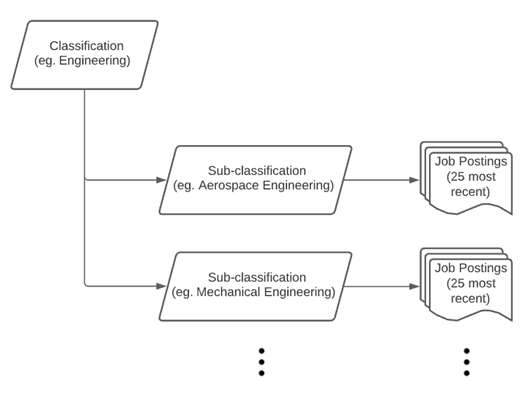
 
As of writing, Seek lists nearly 3,000 job posts for the Developers/Programmers sub classification of the parent Information & Communication Technology classification. By restricting the number of job listings per sub-classification to the 25 most recent, the resulting data set is of a much more manageable size. There also exists a plethora of other sites that contain job postings, including but not limited to: jobsearch.com.au, careerone.com.au, adzuna.com.au, indeed.com.au. These previously listed sites also restrict the job location to Australia. If one were to create a world-wide central repository, the crawler would need to crawl through an unknown but presumably large number of sites that exist for this purpose worldwide. 
Balance Careers provides a large number of employment requirements from their handful of experts in the field, but these requirements they provide are purely a small sample of the total number of skills required. Due to the ever-evolving nature of careers and their required skill sets, choosing just a single site to represent all of the possible skills is severely restricting. Using multiple sites, or by employing industry experts that can stay up to date on current and emerging competencies.

## Complexity of the content layout
The layout of seek.com.au is relatively simple. The search filters are all stored in a html section tag which can easily be extracted through the use of the BeautifulSoup4 (BS4) python package. The selected filters are then used to generate a URL to show results that meet the filters’ criteria. The query results are returned in a paginated format with each page containing around 20 job listings. This pagination hurdle can be solved by appending the ?page=x parameter to the query URL and incrementing the x until we extract the maximum allowed listings of 25. A loop can then be employed to iterate over each article on each page and extract the link to the full listing. Once on the single listing’s page, we aim to extract the job description which can be located in three different elements depending on the layout of the listing. The description can be in a div element with the ‘data-automation’ attribute set to either ‘jobDescription’ or ‘jobAdDetails’. If the description cannot be found in either of those elements, it will be located in the next div element after the job title.

The starting point for the crawler for thebalancecareers will be https://www.thebalancecareers.com/employment-skills-listed-by-job-2062389. This web page contains a plethora of possible job titles, divided by their industry sector, with each job title actually being a link to a dedicated page for this profession. Each individual professions’ page is laid out differently to each other, but each share the fact that they all contain multiple dot point lists of skills. These skill lists are stylised as unordered lists with each list element having no class. There also exists paragraphs of content elaborating on these skill lists, but these paragraphs prove to be of no value for the task at hand. By employing BeautifulSoup once again, the content of each skill list can be extracted and subsequently written to a file.

## Website/data copyright considerations
The robots.txt file present in the majority of websites contains the URLs that are not allowed to be crawled. In this case, both sites’ robot.txt files shows that all the URLs present on the site and are allowed to be crawled. To prevent copy right issues, the logos from the individual companies will not be stored.

## Metadata supplementation and rational for the supplementation
The job descriptions metadata will be supplemented with the title, classification, and sub-classification. The complete skill list, created by appending each individual professions’ list of require skills obtained from thebalancecareers, will be used in conjunction with a manually labelled data set to train a Recurrent Neural Network (RNN) on what a skill is. This RNN will then be used to extract all the skills contained in the job descriptions.

## Content extractor to export the important aspects of the data and/or metadata
The SEEK web crawler will take the parent job description element and combine all the children p tags into a single string. This string will be stored in a csv file under the heading DESCRIPTION. The job title can be obtained by casting the HTML pages’ title attribute to a string and then storing it in the csv file under the TITLE heading. The classification and sub-classification will be available as variables in the workspace but can also be obtained from the webpages’ URL.
The crawler for thebalancecareers will append the unique skills found from each individual profession page to a single skill. This skill list will be written to a csv file with the skills being under the TEXT heading. An additional column titled TARGET will also be written the value of ‘1’ for each skill. This TARGET column will be utilised when training the RNN.


## Code

In [ ]:
import sys
!{sys.executable} -m pip install bs4 pandas lxml html5lib matplotlib

### Seek Crawler

In [ ]:
import csv
import threading
import urllib.request

from bs4 import BeautifulSoup
import re
import pandas as pd
import os
import traceback

MAX_THREADS = 8
DATE_RANGE = 31
POST_PER_SUB_FIELD = 25


def check_has_numbers(input_string):
    return bool(re.search(r'\d', input_string))


def extract_nav():
    filename = "nav.html"
    headers = {
        'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_13_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/68.0.3440.106 Safari/537.36'}
    request = urllib.request.Request(url='https://seek.com.au', headers=headers)
    response = urllib.request.urlopen(request)
    res_html = response.read().decode()
    soup = BeautifulSoup(res_html, "lxml")
    nav = soup.find('nav', attrs={"data-automation": "searchClassification"})
    with open(filename, "w") as file:
        file.write(str(nav))
    return filename


def get_classification_urls(navFile):
    urls = []
    with open(navFile, 'r') as nav:
        soup = BeautifulSoup(nav, 'html.parser')
        els = soup.find_all('a')
        classification = ""
        for el in els:
            label = el['aria-label'].lower()
            # Remove the categories for 'all jobs in {field}' or 'other'
            if label[0:3] == 'all' or label[0:5] == 'other':
                continue
            label = re.sub(r'[\/]', ' ', label)
            label = re.sub(r'[&]', ' ', label)
            label = re.sub(r'[-]', ' ', label)
            label = re.sub(r'[,]', ' ', label)
            label = re.sub(r'[\']', '', label)
            label = re.sub(r'[ ]{2,}', ' ', label)
            label = re.sub(r'[ ]', '-', label.strip())
            if not check_has_numbers(label):
                # Is the field
                classification = 'jobs-in-' + label
            else:
                # is the sub-field
                label = re.sub(r'[0-9](.*)', '', label)
                subclassification = label[:-1]
                urls.append([classification, subclassification])
    return urls


def thread_function(index, data):
    with open(r'data/output{}.csv'.format(index), 'a', newline='', encoding='utf-8-sig') as f:
        writer = csv.writer(f, delimiter=',')
        writer.writerow(['FIELD', 'SUB-FIELD', 'TITLE', 'DESCRIPTION'])

    length = len(data)
    i = 0
    prev_sub_field = ""
    for url in data:
        print("Thread {}: Index {}/{}".format(index, i, length))
        i = i + 1

        if url[1] != prev_sub_field:
            sub_field_total = 0
            prev_sub_field = url[1]

        page_num = 1
        while True:
            if sub_field_total == POST_PER_SUB_FIELD:
                break
            seek_url = ''.join([
                "https://www.seek.com.au/",
                url[0] + '/' + url[1],
                "?daterange=",
                str(DATE_RANGE),
                '&page=',
                str(page_num),
                "&sortmode=ListedDate"
            ])

            try:
                headers = {
                    'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_13_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/68.0.3440.106 Safari/537.36'}
                request1 = urllib.request.Request(url=seek_url, headers=headers)
                response1 = urllib.request.urlopen(request1)
                temp_html = response1.read().decode()
                temp_html = BeautifulSoup(temp_html, "lxml")
                results = temp_html.find_all('article')

                for result in results:
                    if sub_field_total == POST_PER_SUB_FIELD:
                        continue
                    job_title = ''
                    single_page_url = ''
                    try:
                        single_page_url = "https://www.seek.com.au" + result.contents[0].div['href']
                        request2 = urllib.request.Request(url=single_page_url, headers=headers)
                        response2 = urllib.request.urlopen(request2)
                        single_temp_html = response2.read().decode()
                        single_temp_html = BeautifulSoup(single_temp_html, "lxml")

                        job_title = single_temp_html.title.string
                        desc_title = single_temp_html.find('h2', text='Job description')
                        if desc_title is None:
                            job_description = single_temp_html.find(attrs={"data-automation": "jobDescription"})
                            if job_description is None:
                                job_description = single_temp_html.find(attrs={"data-automation": "jobAdDetails"})
                        else:
                            desc_parent = desc_title.find_parent('div')
                            job_description = desc_parent.find_next_sibling("div")
                        desc_text = re.sub('\xa0', ' ',
                                           " ".join(item.strip() for item in job_description.find_all(text=True)))
                        desc_text = desc_text.strip()
                        fields = [url[0],  # Field
                                  url[1],  # Sub-field
                                  job_title,  # Job title
                                  desc_text]  # Job description
                        with open(r'data/output{}.csv'.format(index), 'a', newline='', encoding='utf-8-sig') as file:
                            w = csv.writer(file, delimiter=',')
                            try:
                                w.writerow(fields)
                                sub_field_total = sub_field_total + 1
                            except Exception:
                                print("Thread {}, Index {}: MISSED WRITING TO FILE. URL: {}".format(index, i,
                                                                                                    single_page_url))
                                traceback.print_exc()
                    except Exception:
                        print('{} failed, URL: {}'.format(job_title, single_page_url))
                        traceback.print_exc()
                page_num = page_num + 1
            except Exception:
                print(url[0] + '/' + url[1] + ' failed')
                traceback.print_exc()
                
def preprocess_data(data):
    for column in data:
        data[column] = [re.sub("[\"']", '', elem.lower()) for elem in data[column].tolist()]
        data[column] = [elem.replace("\n", " ") for elem in data[column].tolist()]
        data[column] = [re.sub(r'\s+', ' ', elem) for elem in data[column].tolist()]
        data[column] = [elem.replace(u'\ufffd', '') for elem in data[column].tolist()]
    return data


def rename_job_columns(data):
    data['FIELD'] = [re.sub("[-]", ' ', elem.lower()) for elem in data['FIELD'].tolist()]
    data['FIELD'] = [re.sub("(?:jobs in )", '', elem.lower()) for elem in data['FIELD'].tolist()]
    data['SUB-FIELD'] = [re.sub("[-]", ' ', elem.lower()) for elem in data['SUB-FIELD'].tolist()]
    data['TITLE'] = [re.sub('(?:- seek)', '', elem) for elem in data['TITLE'].tolist()]
    return data


def main():
    nav = extract_nav()
    classification_urls = get_classification_urls('archive/nav.html')
    valid_urls = classification_urls

    """
    MULTI-THREADING
    """
    # Split dataframe into equal amounts
    n = int(len(classification_urls) / MAX_THREADS) + 1
    list_urls = [classification_urls[i:i + n] for i in range(0, len(classification_urls), n)]
    # Instantiate threads
    threads = list()
    for idx in range(MAX_THREADS):
        print("Main: creating and starting thread {}".format(idx))
        x = threading.Thread(target=thread_function, args=(idx, list_urls[idx],))
        threads.append(x)
        x.start()

    for idx, thread in enumerate(threads):
        thread.join()
        print("Main: \tThread {} done".format(idx))

    """
    COMBINING TEMP FILES
    """
    # Combine files
    with open(r'data/job_data.csv', 'a', newline='', encoding='utf-8-sig') as f:
        writer = csv.writer(f, delimiter=',')
        writer.writerow(['FIELD', 'SUB-FIELD', 'TITLE', 'DESCRIPTION'])

    all_files = ['output{}.csv'.format(i) for i in range(MAX_THREADS)]
    combined_descriptions = pd.concat([pd.read_csv(f) for f in all_files])
    # Clean data
    combined_descriptions = preprocess_data(combined_descriptions.copy())
    combined_descriptions = rename_job_columns(combined_descriptions.copy())    
    # export to csv
    combined_descriptions.to_csv("data/clean_seek_data.csv", index=False, encoding='utf-8-sig')
    # Remove temp files
    for file in all_files:
        os.remove(file)

main()

### BalanceCareers Crawler

In [ ]:
import csv
import urllib.request

from bs4 import BeautifulSoup
import traceback

PAGE_URL = "https://www.thebalancecareers.com/employment-skills-listed-by-job-2062389"

if __name__ == "__main__":
    print("Crawling {}".format(PAGE_URL))
    headers = {
        'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_13_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/68.0.3440.106 Safari/537.36'}
    request = urllib.request.Request(url=PAGE_URL, headers=headers)
    response = urllib.request.urlopen(request)
    temp_html = response.read().decode()
    temp_html = BeautifulSoup(temp_html, "lxml")
    uls = temp_html.find_all('ul')

    url_dict = {}
    for x in uls:
        for li in x.find_all('a', {'data-type': 'internalLink'}):
            if "skills-list" in li['href']:
                url_dict[li.text] = li['href']
    # skills-list
    skillList = []
    for key, val in url_dict.items():
        request = urllib.request.Request(url=val, headers=headers)
        response = urllib.request.urlopen(request)
        temp_html = response.read().decode()    
        temp_html = BeautifulSoup(temp_html, "lxml")
        lis = temp_html.find_all('li', attrs={'class': None})
        lis_text = [x.text.lower() for x in lis]
        result_list = list(set(lis_text) | set(skillList))
        skillList = result_list
        print("\t{}".format(val))

    with open(r'data/skills.csv', 'a', newline='', encoding='utf-8-sig') as f:
        writer = csv.writer(f, delimiter=',')
        writer.writerow(['TEXT', 'TARGET'])
    for skill in skillList:
        with open(r'data/skills.csv', 'a', newline='', encoding='utf-8-sig') as file:
            w = csv.writer(file, delimiter=',')
            try:
                w.writerow([skill, '1'])
            except Exception:
                traceback.print_exc()
    print("Done!")


## Crawler Outputs
### Seek Scraper Output
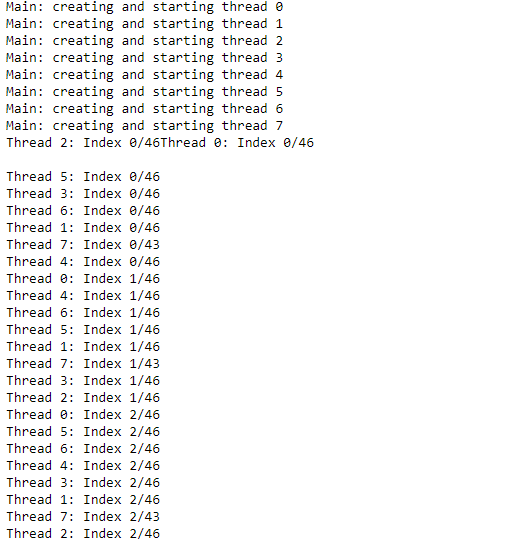

### BalanceCareers Scraper Output
![3.png](attachment:3.png)


## Methodology of processing, cleaning, and storing harvested data for NLP tasking
The Seek web crawler will save its initial data in a comma separated file with four columns:

-	FIELD
-	SUB-FIELD
-	TITLE
-	DESCRIPTION

Processing and cleaning of this retrieved data will be achieved through the use of python’s re package and python’s standard replace function. The re package is used as it provides regular expression matching operations that can be combined with the substitute function to replace the matched pattern. In this case, single and double quotes will be removed from the job descriptions to assist in the NLP tasks. The newline character (\n) is present in the extracted HTML as the job descriptions have been formatted before publishing and will be replaced with a single space. The Unicode replacement character (\ufffd) was found to be causing issues when writing to a csv file. This character was therefore removed from the dataset.

As the field and sub-field values are taken from the constructed URL during the web crawl, they must undergo some processing to be the correct value for the NLP tasks. Seek formats the field value as ‘job-in-FIELD’ eg ‘jobs-in-accounting’. Extracting the field is done with a simple regular expression to remove the “jobs-in-“ section. Due to the job title being taken from the HTML web page, a “ – seek” is appended on the end. This can also be removed with a simple regular expression.
The crawler for thebalancecareers returns clean data due to the skills being extracted being plain text inside p tags. For consistency, all of the skills are converted to lowercase before being stored in a csv file.


## Summary and visualisation of the harvested data
Exploring the scraped Seek data first, we can first look at the shape of the data and see that the crawler retrieved 8866 jobs. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
df = pd.read_csv('data/clean_seek_data.csv')
print(df.shape)
df.head()

(8866, 4)


,FIELD,SUB-FIELD,TITLE,DESCRIPTION
0,accounting,accounts officers clerks,accounts/admin officer job in south west coast...,our amazing business is growing and we need a ...
1,accounting,accounts officers clerks,accounts manager job in brisbane,vicon transfers is the leader in heat transfer...
2,accounting,accounts officers clerks,accounts officer job in gold coast,altran is an award winning construction and sh...
3,accounting,accounts officers clerks,invoicing officer job in melbourne,a privately owned transport company in the sou...
4,accounting,accounts officers clerks,finance officer job in blue mountains & centra...,catholic education diocese of bathurst (cedb) ...


Next we can look at the mean job description word count. 

In [2]:
df1 = df.copy()
df1['COUNT'] = (df['DESCRIPTION'].apply(lambda x: np.round(np.mean(len(x.split())))))
print("Mean job description length: {} words".format(np.round(df1['COUNT'].mean())))

Mean job description length: 373.0 words


After that, we can have a more in depth look into the job description word count per classification. Utilising the pandas boxplot function, we can visualise the minimum, first quartile, median, third quartile, and maximum job description lengths per classification.

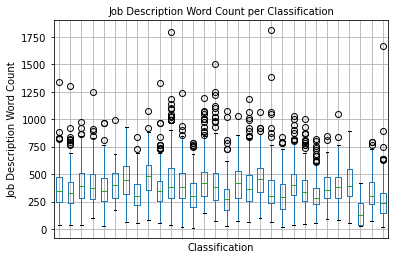

In [3]:
df2 = df.copy()
df2['COUNT'] = df['DESCRIPTION'].apply(lambda x: len(x.split()))
df2 = df2[['FIELD', 'COUNT']].groupby('FIELD')
boxplot = df2.boxplot(subplots=False)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)
plt.xlabel('Classification')
plt.ylabel('Job Description Word Count')
plt.title('Job Description Word Count per Classification', fontsize=10)
plt.show()

We can then plot a histogram of the job description word length to better understand the overall distribution. From the plot, it appears the data is normally distributed around the mean of 373 words. As the data set has over 1000 observations, this can be attributed to the central limit theorem.

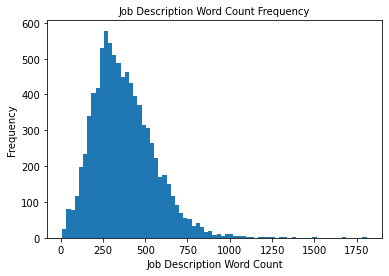

In [4]:
df3 = (df.apply(lambda x: x.str.split().str.len()))\
    .reset_index(drop=True).sort_values("DESCRIPTION").reset_index(drop=True)

plt.hist(df3["DESCRIPTION"], bins=int(len(df3['DESCRIPTION'].unique())/12))
plt.xlabel('Job Description Word Count')
plt.ylabel('Frequency')
plt.title('Job Description Word Count Frequency', fontsize=10)
plt.show()

Exploring the retrieved skills data set next, we can see we successfully scraped 1954 skills from thebalancecareers.

In [5]:
import pandas as pd
df = pd.read_csv('data/skills.csv')
print(df.shape)

(1954, 2)


### References
About SEEK. (2011, August 15). Company NZ. https://www.seek.com.au/about/

About Us. (2018, August 15). The Balance Careers. https://www.thebalancecareers.com/about-us